# 1. Intro to Waveforms

This tutorial demonstrates how to use PyART to download, load waveforms and plot them in a uniform time grid (ensuring they peak at $t=0M$)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy, pylab
import seaborn as sns

# Set up Seaborn aesthetics
sns.set_context('talk') 
sns.set_theme(font_scale=1.2)
sns.set_style('ticks')

# Update matplotlib rcParams
pylab.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
        'axes.grid': True,
        'grid.linestyle': ':',
        'grid.color': '#bbbbbb',
        'axes.linewidth': 1,
    }
)
from PyART.catalogs import sxs, rit

We will first create a file `rit_catalog.json` that contains all the requisite links of all the public RIT simulations available [here](https://ccrgpages.rit.edu/~RITCatalog/)

In [2]:
import requests
from bs4 import BeautifulSoup
import json

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/114.0.0.0 Safari/537.36"
}

url = "https://ccrg.rit.edu/~RITCatalog/"

response = requests.get(url, headers=headers)
response.raise_for_status()  # will raise if server still returns 500

soup = BeautifulSoup(response.text, "html.parser")

catalog = {}
base = "https://ccrg.rit.edu/~RITCatalog/"

for row in soup.find_all("tr"):
    cols = row.find_all("td")
    if len(cols) < 3:
        continue

    # First column contains simulation ID like RIT:BBH:0001
    sim_id_tag = cols[0].get_text(strip=True)
    if not sim_id_tag.startswith("RIT:BBH:"):
        continue
    sim_id = sim_id_tag.split(":")[-1]

    # Third column contains 3 links
    links = cols[2].find_all("a", href=True)
    if len(links) < 3:
        continue

    metadata_url = base + links[0]['href']
    psi4_url = base + links[1]['href']
    strain_url = base + links[2]['href']

    catalog[sim_id] = [metadata_url, psi4_url, strain_url]

# ✅ Save to JSON
with open("rit_catalog.json", "w") as f:
    json.dump(catalog, f, indent=2)

print(f"✅ Saved {len(catalog)} entries to 'rit_catalog.json'")

✅ Saved 1057 entries to 'rit_catalog.json'


In [3]:
waveform_sxs = sxs.Waveform_SXS(
    path='./',
    ID = '1132',
    download=True,
    downloads = ['hlm', 'metadata'],
    load = ['hlm', 'metadata'],
    level = 4,
    order = 2,
    nu_rescale = False
)

waveform_rit = rit.Waveform_RIT(
    path='./',
    urls_json='./catalog_rit.json',
    download=True,
    ID = '0112',
    nu_rescale = False
)

waveforms = {'SXS' : waveform_sxs, 
             'RIT' : waveform_rit}

The model objects in the waveforms dictionary contains the gravitational-wave radiation  multipoles, stored as a dictionary of the form: `hlm[(l,m)]`. Each dictionary entry has the amplitude: `A` and phase `p` of the mode, as well as the `real` and `imag` part of $h_{\ell,m}$.

Since, the peak amplitude time can vary between different waveform models or catalogues, we first do a naive time-alignment the waveforms by shifting their time arrays such that the amplitude $A_{22}(t)$ peaks at $t=0M$ (arbitrary time).

Is u_sxs uniform? False
Is u_rit uniform? False
Is u_common uniform? True
Length of u_common = 15913
Δt 0.333251953125
Is h_sxs_uniform uniform in time domain? True


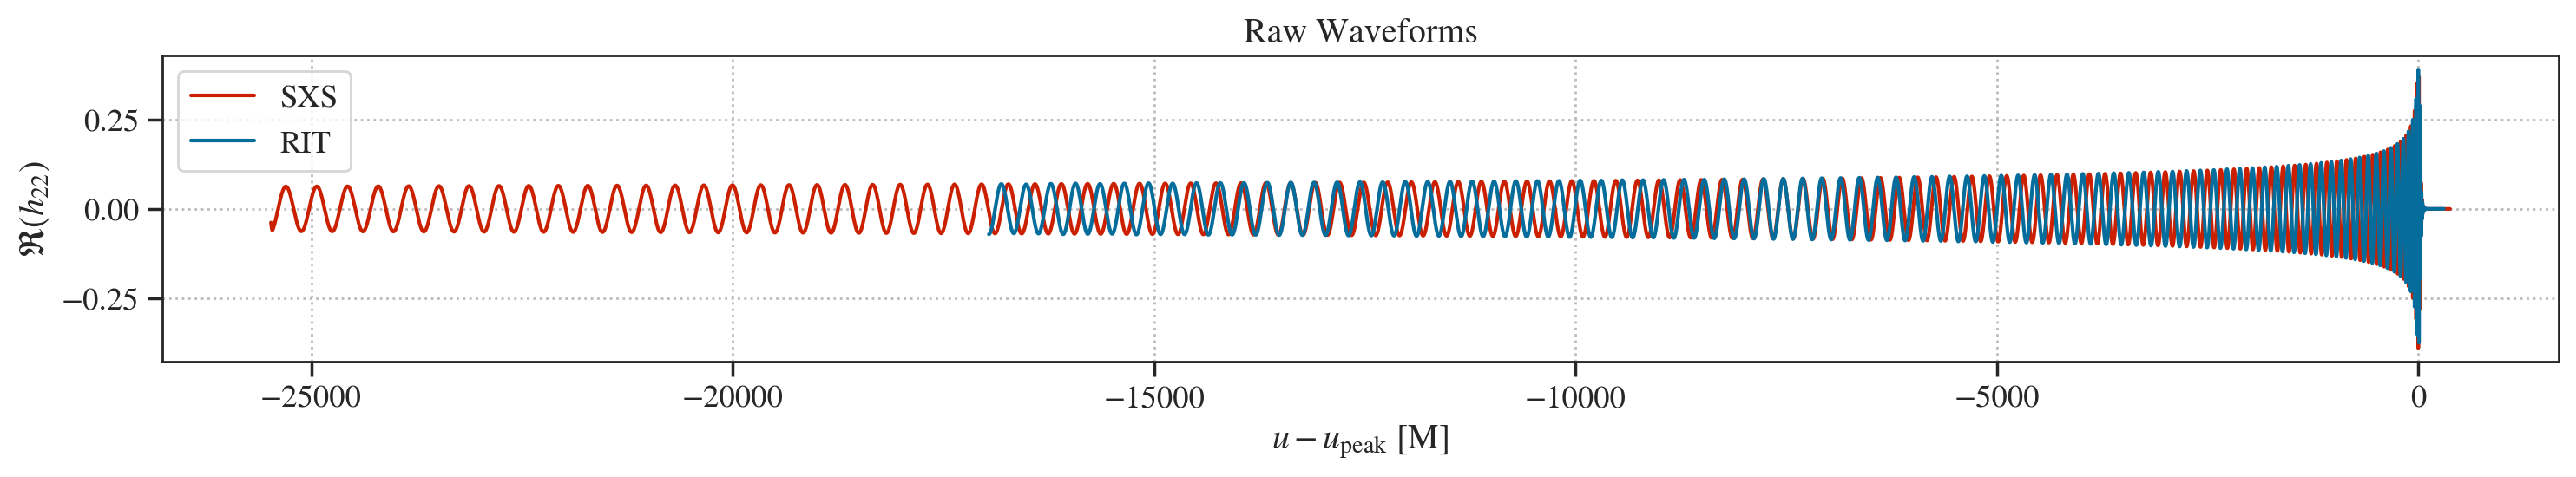

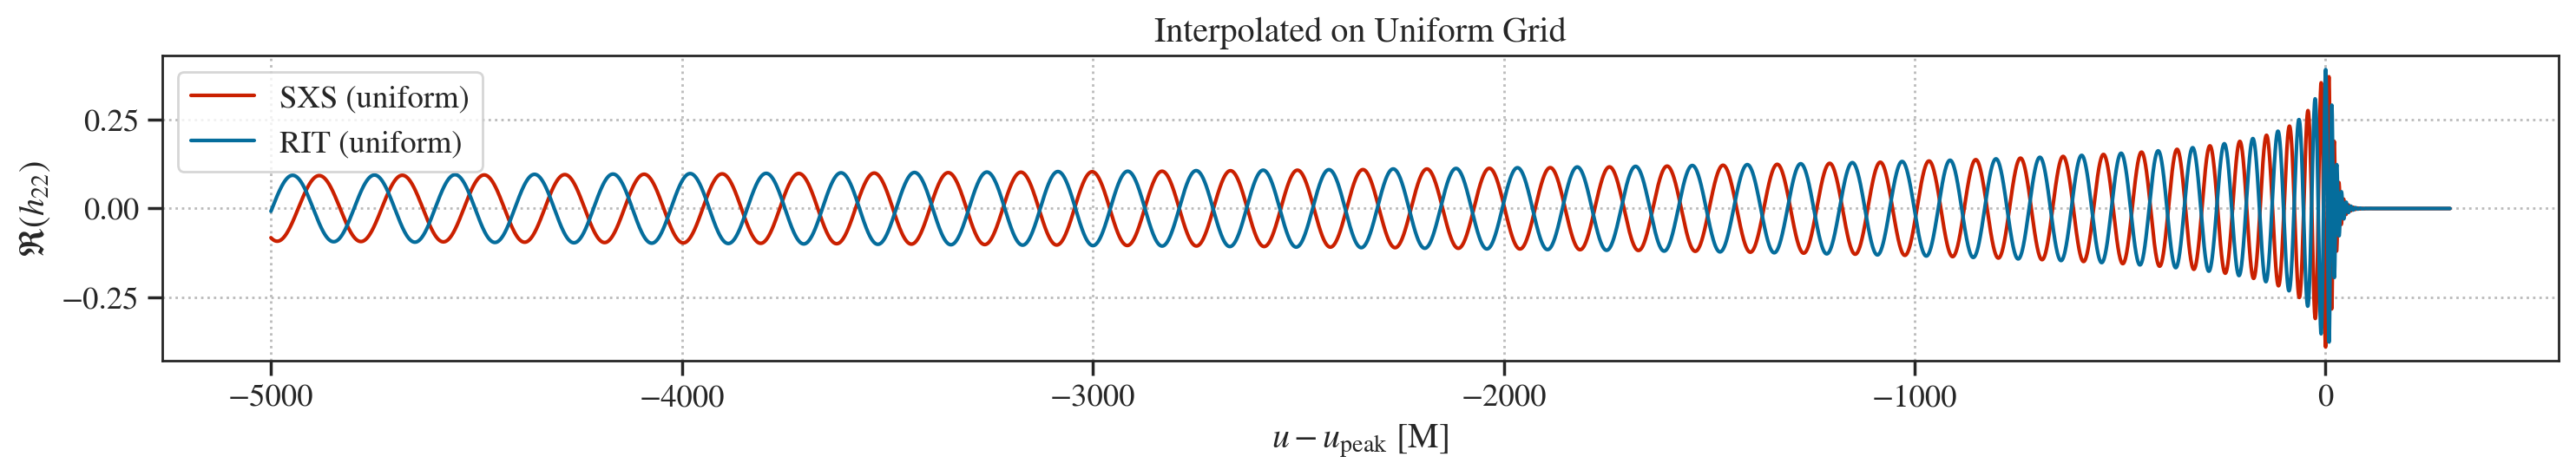

In [4]:
from scipy.interpolate import interp1d
import numpy
import pylab

# Utility function to check if an array is uniformly spaced
def is_uniform(arr, rtol=1e-10, atol=1e-12):
    delta = numpy.diff(arr)
    return numpy.allclose(delta, delta[0], rtol=rtol, atol=atol)

# Load data
u_sxs = waveforms['SXS'].u
u_rit = waveforms['RIT'].u
h_sxs_real = waveforms['SXS'].hlm[(2, 2)]['real']
h_rit_real = waveforms['RIT'].hlm[(2, 2)]['real']

# Check uniformity of raw time arrays
print("Is u_sxs uniform?", is_uniform(u_sxs))
print("Is u_rit uniform?", is_uniform(u_rit))

# Find peak times
t_peak_sxs = u_sxs[numpy.argmax(abs(h_sxs_real))]
t_peak_rit = u_rit[numpy.argmax(abs(h_rit_real))]

# Shift time arrays so peaks align at u = 0 M
u_sxs_shifted = u_sxs - t_peak_sxs 
u_rit_shifted = u_rit - t_peak_rit

# Plot original (uninterpolated) aligned waveforms
pylab.figure(figsize=(15, 3))
pylab.plot(u_sxs_shifted, h_sxs_real, label='SXS', color='#ca2000')
pylab.plot(u_rit_shifted, h_rit_real, label='RIT', color='#056d9c')
pylab.xlabel(r'$u - u_\mathrm{peak}$ [M]')
pylab.ylabel(r'$\Re(h_{22})$')
pylab.legend()
pylab.grid(True)
pylab.title('Raw Waveforms')
pylab.tight_layout()

# Create common uniform time array using RIT’s shifted grid spacing
rit_spacing = numpy.median(numpy.diff(u_rit_shifted))
u_min = max(u_sxs_shifted[0], u_rit_shifted[0], -5000) # Ignore stuff before <-5000M for fun
u_max = min(u_sxs_shifted[-1], u_rit_shifted[-1])
u_common = numpy.arange(u_min, u_max, rit_spacing)

print("Is u_common uniform?", is_uniform(u_common))

# Interpolate onto uniform grid
interp_sxs = interp1d(u_sxs_shifted, h_sxs_real, kind='cubic', bounds_error=False, fill_value=0.0)
interp_rit = interp1d(u_rit_shifted, h_rit_real, kind='cubic', bounds_error=False, fill_value=0.0)

h_sxs_uniform = interp_sxs(u_common)
h_rit_uniform = interp_rit(u_common)

# Final plot
pylab.figure(figsize=(15, 3))
pylab.plot(u_common, h_sxs_uniform, label='SXS (uniform)', color='#ca2000')
pylab.plot(u_common, h_rit_uniform, label='RIT (uniform)', color='#056d9c')
pylab.xlabel(r'$u - u_\mathrm{peak}$ [M]')
pylab.ylabel(r'$\Re(h_{22})$')
pylab.legend()
pylab.grid(True)
pylab.title("Interpolated on Uniform Grid")
pylab.tight_layout()

# Final checks
print("Length of u_common =", len(u_common))
print("Δt", numpy.mean(numpy.diff(u_common)))
print("Is h_sxs_uniform uniform in time domain?", is_uniform(u_common))  # Should be True


As one can see the waveforms are neither phase or time aligned. We will show how to compare the waveforms using both time-domain (phase-alignment) and
frequency-domain (mismatch) comparison in the next tutorial.